# Assignment 1. Coding 2 by [Rufaim](https://github.com/Rufaim)

---

Dynamic Programming on a tabular environments.

Implement tabular policy iteration and value iteration to find the optimal value function and optimal policy.

Report the training performance of these methods with the following plots:
 1. cumulative reward per episode obtained by the agent
 2. the number of timesteps to solve the task per episode of experience, both reported over 5 different seeds (as specified in the beginning of the coding section).
 
For the test performance, after every 10 episodes of training (for every seed), run
the estimated policy in the environment for 5 test episodes and report the mean
over 
 1. cumulative reward per episode obtained by the agent
 2. the number of timesteps required to solve the task per episode of experience. You will extend the reporting scheme over seeds from training. 

In both training and testing plots, highlight the optimal performance (maximum return in an episode / minimum number of timesteps per episode) in a dotted line.

Please provide your own observations with respect to the results obtained. Also,
provide the time complexity, space complexity of these algorithms.


## Imports and Global constants

In [0]:
import numpy as np
import gym  # we will use some of predefined environments
import matplotlib.pyplot as pyplot

In [0]:
# we need these things for a very important
# reason that is probably described below
from scipy.sparse import lil_matrix, identity
from scipy.sparse.linalg import bicgstab

By default we assume that all environment we have are not bounded in amount of steps agent can take per episode, so in the experiments the number of timesteps is bounded by 250. We use 300 edisodes to train agent during experiment. Each 10th episodes agent is tested for 5 episodes with predefined seeds. 


---

Default parameters are:
```python
NUM_TRIALS_TO_AVG = 5
MAX_EPISODES_PER_TRIAL = 300
MAX_TIMESTEPS_PER_EPISODE = 250
STEP_TO_TEST = 10
NUM_TEST_EPISODES = 5
GAMMA = 0.95
SEED = 42
```



In [0]:
NUM_TRIALS_TO_AVG = 5
MAX_EPISODES_PER_TRIAL = 300
MAX_TIMESTEPS_PER_EPISODE = 250
STEP_TO_TEST = 10
NUM_TEST_EPISODES = 5
GAMMA = 0.95
SEED = 42

## Algorithms

In this section we are defining both of our algorithm that we are going to use later for experiments.


### Base Class

What we expect of an algorithm class to comfortably work with? Not much. We would like it to remember limit of iterations and precision, also some reininitialization ability would be great for experiments with multiple episodes. 


In [0]:
class Algorithm(object):
    def __init__(self, max_iterations=10000, eps=1e-10):
        self.max_iterations = max_iterations
        self.eps = eps
        self.reset()
    
    def reset(self):
        self.environment = None
        self.gamma = None
    
    def initialize(self, environment, gamma):
        # checking values and store them
        assert hasattr(environment, 'observation_space')
        assert hasattr(environment, 'action_space')
        # P is mandatory, 
        # since P stores the whole MDP model in a convenient convinient way
        assert hasattr(environment, 'P')    
        assert 0<=gamma<=1

        self.environment = environment
        self.gamma = gamma
        # initializing value-function or policy as array
        self.value = np.zeros((self.environment.observation_space.n,))
        self._initialize() # subclasses can initialize their parameters with this method
    
    def fit(self, environment, gamma):
        self.initialize(environment, gamma)

        for it in range(self.max_iterations):
            print(f"\r  Iteration {it+1} of {self.max_iterations}",end="")
            
            if self.update_step():
                print(f"\n  Convergence on {it} iteration")
                break
        else:
            print()
        return self
    
    ### Methods below are to be defined in the subclasses ###
       
    def _initialize(self):
        '''
        some inner subclass variables to be inititalized in this method
        '''
        pass

    def update_step(self):
        '''
        Does one update step with current environment,
        returns update-cycle break condition.
        '''
        pass
    
    def get_policy(self,recalculate=False):
        '''
        returns algorithm policy;
        (if appliable) if recalculate is True than policy is recalculated, else
        hashed policy is returned
        '''
        pass

### Value Iteration

The first algorithm is value iteration.

---

$
\quad\\
\text{Initialization:} \\
\qquad V(s) ← \text{some values (zeros in our case)}\\
\\
\text{Do} \\
\qquad \text{For} \, \forall s \in S\\
\qquad \qquad \text{For} \, \forall a \in A\\
\qquad \qquad \qquad Q(s,a) ← \mathbb{E}(r |s,a) + \gamma\displaystyle\sum_{s' \in S} \left( P(s'|s,a) V(s') \right) \\
\qquad \qquad V(s) ← \text{max}_a ( Q(s,a))\\
\text{Until} \, V(s)  \, \text{converges}
$

---

*Note:* all complexity asymptotics applicable to implementation rather than general algorithm.

Time complexity is $O(|A||S|^2)$.

Memory complexity is $O(|A| + 2|S|)$.

For memory complexity we assume that for $Q(s,a)$ we store only one row for a particular state $s$ at one time. 

In [0]:
class ValueIteration(Algorithm):  
    def _initialize(self):
        self._policy = None

    def _q_vals_from_state(self, value, state):
        # calculating Q(state,a) for fixed state
        q = np.zeros((self.environment.action_space.n,))
        # P has MDP model, so let's iterate over
        for a in self.environment.P[state]:
            for prob, s_, r, done in self.environment.P[state][a]:
                q[a] += prob * (r + self.gamma * value[s_])
        return q

    def update_step(self):
        old_val = self.value.copy()
        for s in self.environment.P:
            q = self._q_vals_from_state(old_val, s)
            # max_a over Q(s,a)
            # right according to algorithm
            self.value[s] = np.amax(q)
        
        # returning the traincycle-break condition
        # Manhattan norm less than precision value in our case
        return np.sum(np.abs(self.value-old_val)) <= self.eps

    def get_policy(self,recalculate=False):
        # we can not just decorate with @property for hashing,
        # because it is needed  to be recalculated during training steps
        # but having hashed policy for validation is more efficient
        if self._policy is not None and not recalculate:
            return self._policy

        assert self.environment is not None
        assert self.gamma is not None
        
        # policy is a vector of action indexes
        policy = np.zeros((self.environment.observation_space.n,),dtype=int)
        for s in self.environment.P:
            q = self._q_vals_from_state(self.value, s)
            # argmax_a over Q(s,a)
            policy[s] = np.argmax(q)
        
        # hashing policy
        self._policy = policy
        return policy

### Policy Iteration

Policy iteration is slightly more complex than the previous one.

---

$
\quad\\
\text{Initialization:} \\
\qquad \pi'(s) ← \text{some action (zeroth in our case)}\\
\\
\text{Do} \\
\qquad \pi ← \pi'\\
\qquad \text{Solve equation for} \, \pi \\
\qquad \qquad V(s) = \mathbb{E}(r |s,\pi(s)) + \gamma\displaystyle\sum_{s' \in S} \left( P(s'|s,\pi(s)) V(s') \right) \\
\qquad \text{Update} \, \pi' \\
\qquad \qquad \pi'(s) ← \underset{a \in A}{\text{argmax}} \, \mathbb{E}(r |s,a) + \gamma\displaystyle\sum_{s' \in S} \left( P(s'|s,a) V(s') \right) \\
\text{Until} \, \pi \, \text{converges}
$

---

Time complexity is $O\left( (|A|+1)|S|^2 + |S| \right)$.

For time complexity we assume that linear equation solver has near-linear asymptotic.

Memory complexity is $O(3|A| + 2|S| + |S|^2)$.

For memory complexity we assume that for solving for policy we require probability matrix $\underset{|S|\times|S|}{\text{P}}$ to store. 

In [0]:
class PolicyIteration(Algorithm):
    def _solve_for_v_policy(self):
        val_f = np.zeros((self.environment.observation_space.n,))
        # Knowing that optimal value function is a static point of Bellman update operator we
        # could have just apply it multiple time which would require much less memory
        # how ever it would be terribly slow due to python cycles
        mat = lil_matrix((self.environment.observation_space.n,self.environment.observation_space.n))
        rewards = np.zeros((self.environment.observation_space.n,))

        for s in self.environment.P:
            for prob, s_, r, done in self.environment.P[s][self.value[s]]:
                mat[s,s_] = prob
                rewards[s] += prob*r
        
        mat = identity(self.environment.observation_space.n) - self.gamma * mat
        # interesting and useless fact: euclidian norm on residuals is used by BiCGstab to check convergence
        val_f, info = bicgstab(mat, rewards, tol=self.eps, maxiter=self.max_iterations)        
        return val_f
    
    def _extract_new_policy(self,val_f):
        new_policy = np.zeros(self.environment.observation_space.n)
        for s in self.environment.P:
            q = np.zeros((self.environment.action_space.n,))
            for a in self.environment.P[s]:
                for prob, s_, r, done in self.environment.P[s][a]:
                    q[a] += prob * (r + self.gamma * val_f[s_])
            # pi(s) = argmax_a over Q(s,a)
            new_policy[s] = np.argmax(q)
        return new_policy

    def update_step(self):
        v_old_policy = self._solve_for_v_policy()
        new_policy = self._extract_new_policy(v_old_policy)
        # let's assume than policy is cool when it remains the same 
        # after an update step
        done = np.all(self.value == new_policy)
        self.value = new_policy.copy()
        return done

    def get_policy(self, recalculate=False):
        # recalculate is not used here because 
        # bacause policy recalculated on each update step
        # and stored anyway 
        assert self.environment is not None
        assert self.gamma is not None

        return self.value

## Test Framework

In this section there is a testimg frameworks to perform experiments.

The core idea to have this thing is to aggregate all required parameters and then feed pairs of (enviroment, algorithm) into it to obtair results.

We would like to have the following plots:

1. cumulative reward per episode averaged over 5 runs
1. number of timesteps till finish over averaged over 5 runs
1. cumulative reward averaged over 5 test episodes after every 10 episodes of trainings averaged over 5 runs
1. number of timesteps till finish averaged over 5 test episodes after every 10 episodes of trainings averaged over 5 runs


In [0]:
class TestFramework(object):
    def __init__(self, num_trials, max_episodes, max_timesteps, test_each_step=10, \
                 test_episodes=5, seed=None):
        self.num_trials = num_trials
        self.max_episodes = max_episodes
        self.max_timesteps = max_timesteps
        self.test_step = test_each_step
        self.test_episodes = test_episodes
        self.seed = seed

        self.reset()

    def reset(self,seed=None):
        '''
        Used to set a particular seed or reset framework by setting default one
        '''
        if seed is None:
            self.random_generator = np.random.RandomState(seed=self.seed)
        else:
            self.random_generator = np.random.RandomState(seed=seed)
    
    def generate_seeds(self,amount=1):
        # we want moar, we need moar
        # it's seeds. We hunger for...
        return self.random_generator.randint(1000000000, size=amount)
    
    def run_episode(self, environment, policy, seed):
        '''
        Does a run of an environment with given policy (and seed)

        environment : an instance of gym.Environment having 
                   observation_space, action_space and P porperties
        policy      : list of size |S| for mapping 
                      index of state to index of prefferd action
        seed        : seed to reset environment with

        returns     : cumulative reward and time
        '''
        cum_reward = 0
        environment.seed(seed)
        state = environment.reset()
        for time in range(self.max_timesteps):
            state, reward, done , _ = environment.step(policy[state])
            cum_reward += reward

            if done:
                break
        
        return cum_reward, time+1
    
    def run_trial(self,environment, algorithm, gamma):
        '''
        Running one complete experiment and returns lists of experimental results

        environment : an instance of gym.Environment having 
                   observation_space, action_space and P porperties
        algorithm   : an instance of the Algorithm class
        gamma       : discount factor

        returns     : cumulative reward per episode, 
                      number of timesteps till finish,
                      cumulative test reward,
                      test number of timesteps till finish
        '''
        reward = []
        time = []
        test_reward = []
        test_time = []
        # You know what? instead of having pairs of (enviroment, algorithm)
        # we would have triples of (enviroment, algorithm, gamma)
        # because everyone loves gamma (especially high one)

        algorithm.reset()
        algorithm.initialize(environment, gamma)

        episode_seeds = self.generate_seeds(self.max_episodes)
        test_seeds = self.generate_seeds(self.test_episodes)
        
        for ep in range(self.max_episodes):
            done = algorithm.update_step()

            r, t = self.run_episode(environment, algorithm.get_policy(True), int(episode_seeds[ep]))
            reward.append(r)
            time.append(t)
            
            if ep % self.test_step == 0:
                t_r = 0
                t_t = 0
                for test_ep in range(self.test_episodes):
                    r, t = self.run_episode(environment, algorithm.get_policy(),int(test_seeds[test_ep]))
                    t_r += r
                    t_t += t
                test_reward.append(t_r/self.test_episodes)
                test_time.append(t_t/self.test_episodes)
            
            if done:
                break
        
        return reward, time, test_reward, test_time
    
    def run_experiment(self, environment, algorithm, gamma):
        '''
        Running one complete experiment and returns lists of experimental results

        environment : still an instance of gym.Environment having 
                   observation_space, action_space and P porperties
        algorithm   : an instance of the Algorithm class
        gamma       : discount factor

        returns     : averaged cumulative reward per episode, 
                      averaged number of timesteps till finish,
                      averaged cumulative test reward,
                      averaged test number of timesteps till finish
        '''
        reward = 0
        time = 0
        test_r = 0
        test_time = 0

        seeds = self.generate_seeds(self.num_trials)

        for trial in range(self.num_trials):
            print(f"\rTrial {trial+1} of {self.num_trials}",end="")
            
            self.reset(int(seeds[trial]))
            r, t, t_r, t_t = self.run_trial(environment,algorithm,gamma)
            # Yep, this is a wrapper around trials runner
            # that aggregate results
            reward += np.array(r)
            time += np.array(t)
            test_r += np.array(t_r)
            test_time += np.array(t_t)
        
        print()
        return reward/self.num_trials, time/self.num_trials, test_r/self.num_trials, test_time/self.num_trials

We also highlight the optimal performance values on training and testing plots.

In [0]:
def plot_results(results_tup, title):
    '''
    Here we have a convenient way to turn output of 'run_experiment' to banch of plots.
    This function produces both couples train and test plots (four plots in total)
    Please, make sure you have read the code and got scared.

    results_tup : all four outputs for of 'run_experiment' method
    title       : main title of the block
    '''
    figure, [[ax_r,ax_t_r],[ax_t,ax_t_t]] = pyplot.subplots(2, 2,figsize=(22,6))

    # detupling the results
    reward, time, test_r, test_time = results_tup

    figure.subplots_adjust(wspace=0.25)

    figure.suptitle(title, fontsize=22, fontweight="bold")
    
    ## train reward plot
    ax_r.plot(reward, color="b",label="Reward", alpha=0.7)
    max_val_r = np.amax(reward) # max of reward level
    ax_r.axhline(y = max_val_r, color="orange", linestyle="-.",label="Min Reward")
    ax_r.legend(loc="upper left",bbox_to_anchor=(1.015,1.0))
    ax_r.set_title("Reward and Time (training)", fontsize=18)
    # pointing to the first peak of maximum 
    x = 0.5*(np.argmax(reward)+len(reward)//2)
    y = 0.4*(np.amin(reward)+max_val_r) + max_val_r
    ax_r.annotate('Earliest Reward Maximum', (np.argmax(reward), max_val_r),
            xytext=(x, y), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=14,
            horizontalalignment='center', verticalalignment='top')
    bottom, top = ax_r.get_ylim()
    ax_r.set_ylim(bottom, 1.5*top)

    ## plotting train time to complete 
    ax_t.plot(time, color="r",label="Time", alpha=0.7)
    min_val_t = np.amin(time)  # min of time level
    ax_t.axhline(y=min_val_t, color="orange", linestyle="-.",label="Min Time")
    ax_t.legend(loc="upper left",bbox_to_anchor=(1.025,1.0))
    # pointing to the first peak of minimum 
    x = 0.5*(np.argmin(time)+len(time)//2)
    y = min_val_t - 0.15*(np.amax(time)+min_val_t)
    ax_t.annotate('Earliest Time Minimum', (np.argmin(time), min_val_t),
            xytext=(x, y), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=14,
            horizontalalignment='center', verticalalignment='top')
    
    ## test reward plot
    # to be cosistenc=t with previous two plots
    # we stretch our episodes axis for both of tests plots
    test_ticks = np.arange(len(test_r),dtype=np.int)*STEP_TO_TEST
    ax_t_r.plot(test_ticks,test_r, color="b",label="Reward", alpha=0.7)
    max_val_t_r = np.amax(test_r)   # max of test reward level
    ax_t_r.axhline(y = max_val_t_r, color="orange", linestyle="-.",label="Min Reward")
    ax_t_r.set_title("Reward and Time (testing)", fontsize=18)
    # pointing to the first peak of maximum 
    x = 0.5*(np.argmax(test_r)+len(test_r)//2)*STEP_TO_TEST
    y = 0.4*(np.amin(test_r)+max_val_t_r) + max_val_t_r
    ax_t_r.annotate('Earliest Reward Maximum', (np.argmax(test_r)*STEP_TO_TEST, max_val_t_r),
            xytext=(x, y), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=14,
            horizontalalignment='center', verticalalignment='top')
    bottom, top = ax_t_r.get_ylim()
    ax_t_r.set_ylim(bottom, 1.5*top)
    
    ## plotting test time to complete 
    ax_t_t.plot(test_ticks,test_time, color="r",label="Time", alpha=0.7)
    min_val_t_t = np.amin(test_time)  # min of test time level
    ax_t_t.axhline(y = min_val_t_t, color="orange", linestyle="-.",label="Min Time")
    # pointing to the first peak of minimum
    x = 0.5*(np.argmin(test_time)+len(test_time)//2)*STEP_TO_TEST
    y = min_val_t_t - 0.15*(np.amax(test_time)+min_val_t_t)
    ax_t_t.annotate('Earliest Time Minimum', (np.argmin(test_time)*STEP_TO_TEST, min_val_t_t),
            xytext=(x, y), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=14,
            horizontalalignment='center', verticalalignment='top')

## Experiments

In this section we would have two environment of gym list to experiment with.
First one is **Frozen lake** and second is **Taxi**.

For each environment we check the performance of both algorithms on. Thus, there will be four experiments in total (and sixteen plots!)

First of all let's make an instances of test framework and both of the algorithms.

In [0]:
# One test framework, two experiments. 
# So satisfyingly consistent
test_framework = TestFramework(NUM_TRIALS_TO_AVG,MAX_EPISODES_PER_TRIAL, \
                               MAX_TIMESTEPS_PER_EPISODE,STEP_TO_TEST,NUM_TEST_EPISODES,SEED)

In [0]:
value_iteration = ValueIteration(MAX_TIMESTEPS_PER_EPISODE,eps=1e-10)
# We are using differend epsilons for differend algorithms
# because thay have same name but differend meaning depend on the algorithm
policy_iteration = PolicyIteration(MAX_TIMESTEPS_PER_EPISODE,eps=1e-5)

### Experimental results expectations

Before we begin experiments, let me quikly describe expectations of the experimental outcomes.

Generally, reward is expected to be maximazed while time tends to an minimum constant. At some episode they are expepcted to became stationary around some constants. Also they are expected to cover major of the distance towards stationary levels during first fifty episodes.

Test plots are expected to behave in the same way, but in opposite to train plots be noiseless. So stationary levels would be a real reward maximum and a time minimum.

### Frozen lake

For the first experiments we use Frozen Lake enviroment with predefined map "8x8". Agent controls the movement of a character on a grid. The goal is to maake a path from start tile to finish one. The main feature of the environment that outcome of an action is unsertain (ice is slippery!) and only partially depends on the chosen direction.


In [0]:
frozen_lake_env = gym.make('FrozenLake8x8-v0')

Trial 5 of 5


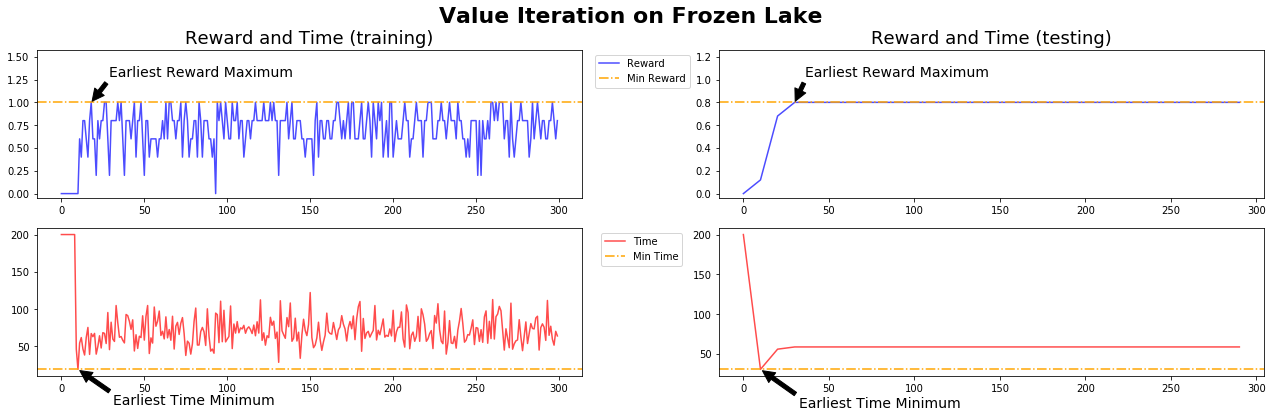

In [12]:
# For reproducibility we resetting test framework before each experiment
test_framework.reset()
res = test_framework.run_experiment(frozen_lake_env,value_iteration,GAMMA)
plot_results(res, "Value Iteration on Frozen Lake")

Trial 5 of 5


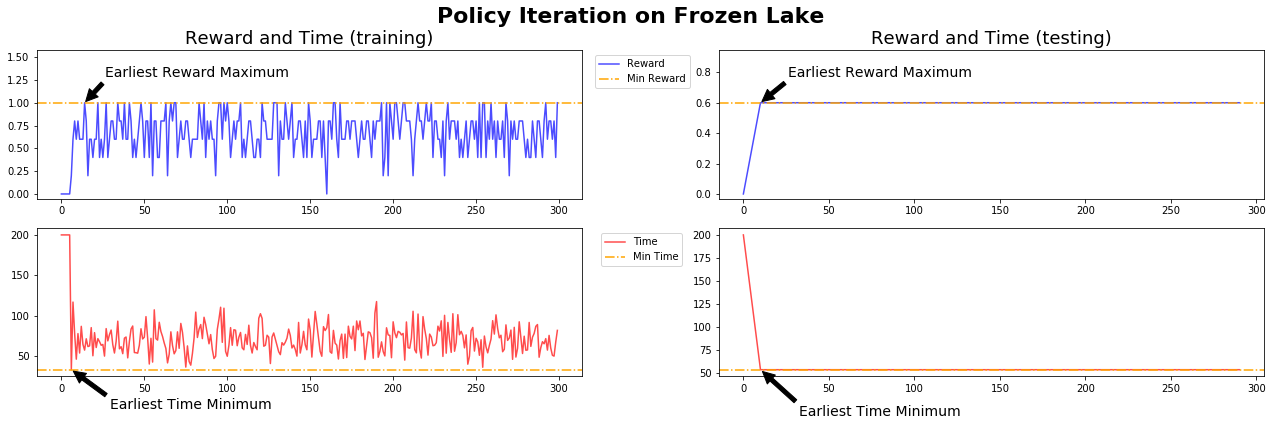

In [13]:
test_framework.reset()
res = test_framework.run_experiment(frozen_lake_env,policy_iteration,GAMMA)
plot_results(res, "Policy Iteration on Frozen Lake")

### Taxi

In [0]:
taxi_env = gym.make("Taxi-v3")

Trial 5 of 5


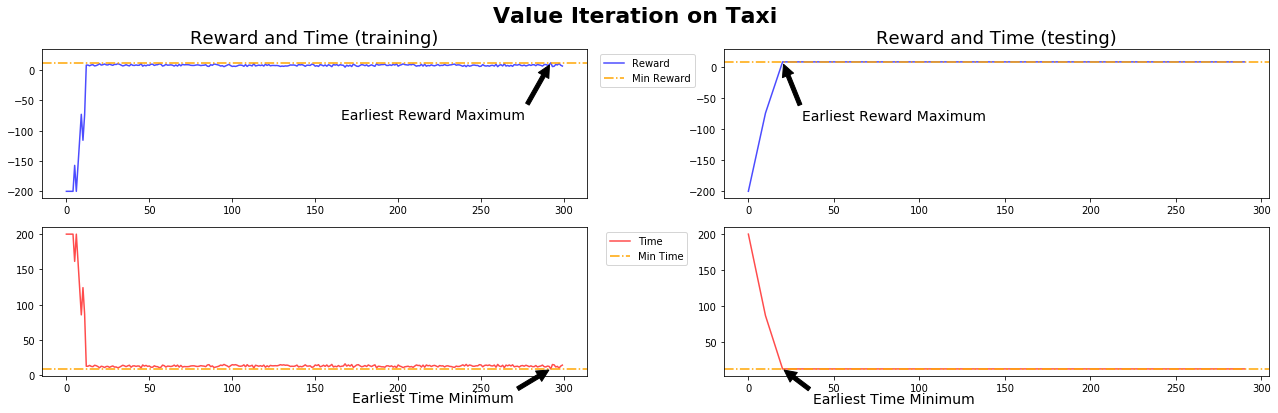

In [15]:
test_framework.reset()
res = test_framework.run_experiment(taxi_env,value_iteration,GAMMA)
plot_results(res, "Value Iteration on Taxi")

Trial 5 of 5


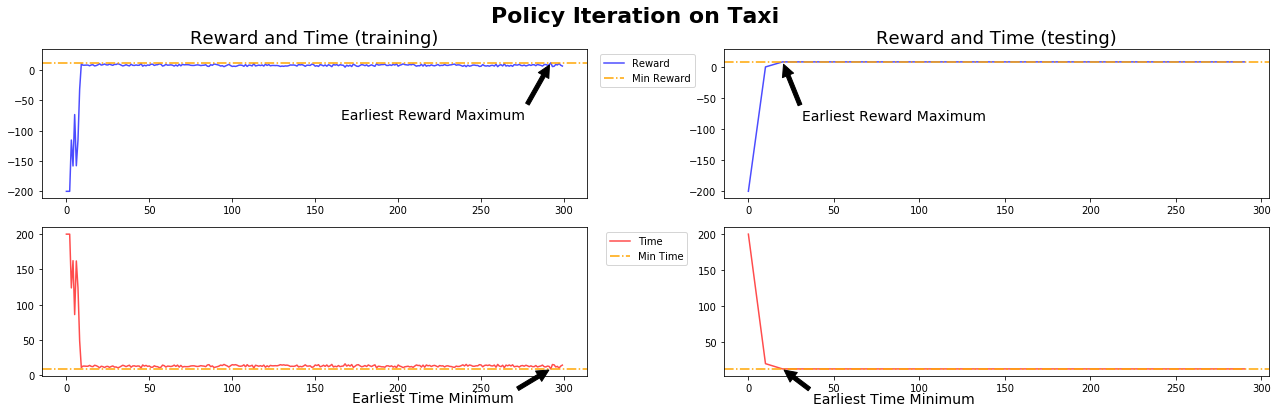

In [16]:
test_framework.reset()
res = test_framework.run_experiment(taxi_env,policy_iteration,GAMMA)
plot_results(res, "Policy Iteration on Taxi")

### Results discussion

What could we say about results? They are coincide expectation in overall. Reward is increasing during trainig while required time is decreasing. However less episodes is required to reach stationary levels than expected.
Beside that for Frozen Lake environment minimum of time appear early than a stationary level is unexpected feature of behaviour. It means that in this environment stationary level of reward does not correspond minimum on time. 